# Book Recommendation System

## Content

1. About Dataset
2. Libraries and Utilities
3. Preprocessing
4. Item-Based Collaborative Filtering
5. Content-Based Collaborative Filtering using *Title, Author, Publisher, Category* as features
6. Content-Based Collaborative Filtering using *Summary* as a feature
7. Custom Recommender
8. Comparison of All Recommenders

# About Dataset

Contains 278,858 users (anonymized but with demographic information) providing 1,149,780 ratings (explicit / implicit) about 271,379 books.

# Install Library

In [2]:
%pip install pandas
%pip install matplotlib
%pip install requests
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Libraries and Utilities

In [3]:
import os
import re
import requests
import warnings
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.corpus import stopwords
nltk.download("stopwords")

from PIL import Image
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('archive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

archive/Books Data with Category Language and Summary/Preprocessed_data.csv
archive/Books Data with Category Language and Summary/.ipynb_checkpoints/Preprocessed_data-checkpoint.csv
archive/Book reviews/Book reviews/BX_Books.csv
archive/Book reviews/Book reviews/BX-Users.csv
archive/Book reviews/Book reviews/BX-Book-Ratings.csv


# Load and Check Data

In [4]:
books = pd.read_csv('archive/Books Data with Category Language and Summary/Preprocessed_data.csv')
books.head(3)

,Unnamed: 0,user_id,location,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_s,img_m,img_l,Summary,Language,Category,city,state,country
0,0,2,"stockton, california, usa",18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,Provides an introduction to classical myths pl...,en,['Social Science'],stockton,california,usa
1,1,8,"timmins, ontario, canada",34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],timmins,ontario,canada
2,2,11400,"ottawa, ontario, canada",49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",en,['Actresses'],ottawa,ontario,canada


# Preprocessing

In [5]:
df = books.copy()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.drop(columns = ['Unnamed: 0','location','isbn',
                   'img_s','img_m','city','age',
                   'state','Language','country',
                   'year_of_publication'],axis=1,inplace = True) #remove useless cols

df.drop(index=df[df['Category'] == '9'].index, inplace=True) #remove 9 in category

df.drop(index=df[df['rating'] == 0].index, inplace=True) #remove 0 in rating

df['Category'] = df['Category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())

df.head(2)

,user_id,rating,book_title,book_author,publisher,img_l,Summary,Category
1,8,5,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses
4,67544,8,Clara Callan,Richard Bruce Wright,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,"In a small town in Canada, Clara Callan reluct...",Actresses


In [9]:
book_title = str("The Testament")
if book_title in df['book_title'].values:
    data =df['book_title'].value_counts()
    rating_counts = pd.DataFrame(data)
    rare_books = rating_counts[rating_counts.values <= 100].index
    common_books = df[~df['book_title'].isin(rare_books)]
    
    if book_title in rare_books:    
        random = pd.Series(common_books['book_title'].unique()).sample(2).values
        print('There are no recommendations for this book')
        print('Try: \n')
        print('{}'.format(random[0]),'\n')
        print('{}'.format(random[1]),'\n')
    else:
        common_books = common_books.drop_duplicates(subset=['book_title'])
        common_books.reset_index(inplace= True)
        common_books['index'] = [i for i in range(common_books.shape[0])]
        target_cols = ['book_title','book_author','publisher','Category']
        common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
        cv = CountVectorizer()
        count_matrix = cv.fit_transform(common_books['combined_features'])
        cosine_sim = cosine_similarity(count_matrix)
        index = common_books[common_books['book_title'] == book_title]['index'].values[0]
        sim_books = list(enumerate(cosine_sim[index]))
        sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                    reverse=True)[1:17]
        
        books = []
        for i in range(len(sorted_sim_books)):
            books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['index'].item())
        
        print(books)
else:
    print('Cant find book in dataset, please check spelling')

[59, 7, 87, 97, 78, 39, 18, 16, 53, 51, 77, 33, 9, 99, 30, 20]


# Item-Based Collaborative Filtering

In [36]:
def item_based_recommender(book_title):
    
    book_title = str(book_title)
    if book_title in df['book_title'].values:
        data =df['book_title'].value_counts()
        rating_counts = pd.DataFrame(data)
        rare_books = rating_counts[rating_counts.values <= 180].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:    
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        else:
            user_book_df = common_books.pivot_table(index=['user_id'],
                                                    columns=['book_title'],
                                                    values='rating')

            book = user_book_df[book_title]
            recom_data = pd.DataFrame(user_book_df.corrwith(book).
                                    sort_values(ascending=False)).reset_index(drop=False)
            
            # remove book_title in rcm_data
            if book_title in [book for book in recom_data['book_title']]:
                recom_data = recom_data.drop(recom_data[recom_data['book_title'] == book_title].index[0])
            
            low_rating = []
            for i in recom_data['book_title']:
                if df[df['book_title'] == i]['rating'].mean() < 5:
                    low_rating.append(i)
                    
            # filter book low rating if count of book rcm > 16
            if recom_data.shape[0] - len(low_rating) > 16:
                recom_data = recom_data[~recom_data['index'].isin(low_rating)]
            
            recom_data = recom_data[0:16]
            recom_data.columns = ['id','corr']
            
            print(recom_data)
    else:
        print('Cant find book in dataset, please check spelling')

In [37]:
item_based_recommender('Fahrenheit 451')

                                           book_title      corr
1                  The Five People You Meet in Heaven  0.944911
2                          Interview with the Vampire  0.939336
3                                   The Da Vinci Code  0.867722
4                               Bridget Jones's Diary  0.835619
5   Harry Potter and the Sorcerer's Stone (Harry P...  0.761885
6   Tuesdays with Morrie: An Old Man, a Young Man,...  0.745356
7                              Snow Falling on Cedars  0.681919
8                                            Timeline  0.670552
9                           Girl with a Pearl Earring  0.657794
10       Harry Potter and the Goblet of Fire (Book 4)  0.572896
11                The Red Tent (Bestselling Backlist)  0.554700
12                                    A Painted House  0.547723
14                              To Kill a Mockingbird  0.237833
15                             The Catcher in the Rye  0.189140
16  Harry Potter and the Order of the Ph

In [8]:
item_based_recommender('The Street Lawyer')

['Girl with a Pearl Earring', "Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson", 'The Testament', 'The Red Tent (Bestselling Backlist)', 'The Secret Life of Bees']


In [9]:
item_based_recommender('Divine Secrets of the Ya-Ya Sisterhood: A Novel')

['The Fellowship of the Ring (The Lord of the Rings, Part 1)', 'Snow Falling on Cedars', 'A Time to Kill', 'The Nanny Diaries: A Novel', 'The Testament']


# Content-Based Collaborative Filtering

## Title, Author, Publisher, Category

In [48]:
def content_based_recommender(book_title):
    
    book_title = str(book_title)
    if book_title in df['book_title'].values:
        data =df['book_title'].value_counts()
        rating_counts = pd.DataFrame(data)
        rare_books = rating_counts[rating_counts.values <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            target_cols = ['book_title','book_author','publisher','Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],
                                      reverse=True)[1:6]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
            
            print(books)
            '''
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(books)):
        
                url = common_books.loc[common_books['book_title'] == books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == books[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
            '''      
    else:
        
        print('Cant find book in dataset, please check spelling')

In [ ]:
content_based_recommender('The Testament')

['The Rainmaker', 'The Street Lawyer', 'The Chamber', 'The Summons', 'The Brethren']


In [ ]:
content_based_recommender('1st to Die: A Novel')

['When the Wind Blows', 'Along Came a Spider (Alex Cross Novels)', 'A Walk to Remember', "Suzanne's Diary for Nicholas", 'The Bridges of Madison County']


In [ ]:
content_based_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

['Harry Potter and the Chamber of Secrets (Book 2)', 'Harry Potter and the Prisoner of Azkaban (Book 3)', 'Harry Potter and the Goblet of Fire (Book 4)', "Harry Potter and the Sorcerer's Stone (Book 1)", "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"]


## Summary

In [ ]:
def content_based_recommender2(book_title):
    
    book_title = str(book_title)
    if book_title in df['book_title'].values:
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 100].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            
            summary_filtered = []
            for i in common_books['Summary']:
                
                i = re.sub("[^a-zA-Z]"," ",i).lower()
                i = nltk.word_tokenize(i)
                i = [word for word in i if not word in set(stopwords.words("english"))]
                i = " ".join(i)
                summary_filtered.append(i)
            
            common_books['Summary'] = summary_filtered   
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['Summary'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:6]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
            
            print(books)
            '''
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(books)):
        
                url = common_books.loc[common_books['book_title'] == books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == books[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()
            '''
    else:
        
        print('Cant find book in dataset, please check spelling')

In [ ]:
content_based_recommender2('To Kill a Mockingbird')

["Bridget Jones's Diary", 'The Green Mile', 'Empire Falls', 'The King of Torts', 'Divine Secrets of the Ya-Ya Sisterhood: A Novel']


In [ ]:
content_based_recommender2('A Walk to Remember')

['Message in a Bottle', 'Dreamcatcher', 'Confessions of a Shopaholic (Summer Display Opportunity)', 'Little Altars Everywhere: A Novel', 'Empire Falls']


In [ ]:
content_based_recommender2('A Painted House')

['The Last Precinct', 'The God of Small Things', 'A Heartbreaking Work of Staggering Genius', 'Midnight in the Garden of Good and Evil: A Savannah Story', 'Fall On Your Knees (Oprah #45)']


# Custom Recommender

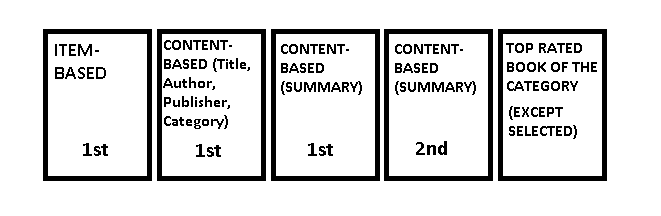

In [ ]:
def custom_recommender(book_title):
    
    #ITEM-BASED
    book_title = str(book_title)
    if book_title in df['book_title'].values:
    
        rating_counts = pd.DataFrame(df['book_title'].value_counts())
        rare_books = rating_counts[rating_counts['book_title'] <= 180].index
        common_books = df[~df['book_title'].isin(rare_books)]
        
        if book_title in rare_books:
            
            random = pd.Series(common_books['book_title'].unique()).sample(2).values
            print('There are no recommendations for this book')
            print('Try: \n')
            print('{}'.format(random[0]),'\n')
            print('{}'.format(random[1]),'\n')
        
        else:
            user_book_df = common_books.pivot_table(index=['user_id'],
                                                    columns=['book_title'], values='rating')
        
            book = user_book_df[book_title]  
            recom_data = pd.DataFrame(user_book_df.corrwith(book). \
                                      sort_values(ascending=False)).reset_index(drop=False)
            
            if book_title in [book for book in recom_data['book_title']]:
                recom_data = recom_data.drop(recom_data[recom_data['book_title'] == book_title].index[0])
                
            low_rating = []
            for i in recom_data['book_title']:
                if df[df['book_title'] == i]['rating'].mean() < 5:
                    low_rating.append(i)
                    
            if recom_data.shape[0] - len(low_rating) > 5:
                recom_data = recom_data[~recom_data['book_title'].isin(low_rating)]
            
            recom_data = recom_data[0:1]    
            recom_data.columns = ['book_title','corr']
            recommended_books = []
            for i in recom_data['book_title']:
                recommended_books.append(i)
                
            df_new = df[~df['book_title'].isin(recommended_books)]
            
            #CONTENT-BASED (Title, Author, Publisher, Category)
            rating_counts = pd.DataFrame(df_new['book_title'].value_counts())
        
            rare_books = rating_counts[rating_counts['book_title'] <= 100].index
    
            common_books = df_new[~df_new['book_title'].isin(rare_books)]
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]   
            target_cols = ['book_title','book_author','publisher','Category']
            common_books['combined_features'] = [' '.join(common_books[target_cols].iloc[i,].values) for i in range(common_books[target_cols].shape[0])]
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['combined_features'])
            cosine_sim = cosine_similarity(count_matrix)
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:2]
            
            books = []
            for i in range(len(sorted_sim_books)):
                books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
                
            for i in books:
                recommended_books.append(i)
            
            df_new = df_new[~df_new['book_title'].isin(recommended_books)]
            
            #CONTENT-BASED (SUMMARY)
            rating_counts = pd.DataFrame(df_new['book_title'].value_counts())
            rare_books = rating_counts[rating_counts['book_title'] <= 100].index
            common_books = df_new[~df_new['book_title'].isin(rare_books)]
            
            common_books = common_books.drop_duplicates(subset=['book_title'])
            common_books.reset_index(inplace= True)
            common_books['index'] = [i for i in range(common_books.shape[0])]
            
            summary_filtered = []
            for i in common_books['Summary']:
                
                i = re.sub("[^a-zA-Z]"," ",i).lower()
                i = nltk.word_tokenize(i)
                i = [word for word in i if not word in set(stopwords.words("english"))]
                i = " ".join(i)
                summary_filtered.append(i)
            
            common_books['Summary'] = summary_filtered
            cv = CountVectorizer()
            count_matrix = cv.fit_transform(common_books['Summary'])
            cosine_sim = cosine_similarity(count_matrix) 
            index = common_books[common_books['book_title'] == book_title]['index'].values[0]
            sim_books = list(enumerate(cosine_sim[index]))
            sorted_sim_books2 = sorted(sim_books,key=lambda x:x[1],reverse=True)[1:4]
            sorted_sim_books = sorted_sim_books2[:2]
            summary_books = []
            for i in range(len(sorted_sim_books)):
                summary_books.append(common_books[common_books['index'] == sorted_sim_books[i][0]]['book_title'].item())
                
            for i in summary_books:
                recommended_books.append(i)
                
            df_new = df_new[~df_new['book_title'].isin(recommended_books)]
            
            #TOP RATED OF CATEGORY
            category = common_books[common_books['book_title'] == book_title]['Category'].values[0]
            top_rated = common_books[common_books['Category'] == category].groupby('book_title').agg({'rating':'mean'}).reset_index()
            
            if top_rated.shape[0] == 1:
                recommended_books.append(common_books[common_books['index'] == sorted_sim_books2[2][0]]['book_title'].item())
                
            else:
                top_rated.drop(top_rated[top_rated['book_title'] == book_title].index[0],inplace=True)
                top_rated = top_rated.sort_values('rating',ascending=False).iloc[:1]['book_title'].values[0]
                recommended_books.append(top_rated)
                
            print(recommended_books)
            '''
            fig, axs = plt.subplots(1, 5,figsize=(18,5))
            fig.suptitle('You may also like these books', size = 22)
            for i in range(len(recommended_books)):
        
                url = df.loc[df['book_title'] == recommended_books[i],'img_l'][:1].values[0]
                im = Image.open(requests.get(url, stream=True).raw)
                axs[i].imshow(im)
                axs[i].axis("off")
                axs[i].set_title('Rating: {}'.format(round(df[df['book_title'] == recommended_books[i]]['rating'].mean(),1)),
                             y=-0.18,
                                 color="red",
                                 fontsize=18)
                fig.show()     
            '''  
    else:
        print('Cant find book in dataset, please check spelling')

In [ ]:
custom_recommender('The Summons')

['Harry Potter and the Order of the Phoenix (Book 5)', 'The Chamber', 'Cold Mountain : A Novel', "ANGELA'S ASHES", 'Snow Falling on Cedars']


In [ ]:
custom_recommender('Snow Falling on Cedars')

['A Painted House', 'Empire Falls', 'Midnight in the Garden of Good and Evil: A Savannah Story', "Angela's Ashes (MMP) : A Memoir", 'SHIPPING NEWS']


In [ ]:
custom_recommender("Tuesdays with Morrie: An Old Man, a Young Man, and Life's Greatest Lesson")

['A Time to Kill', "ANGELA'S ASHES", 'The Five People You Meet in Heaven', 'Interview with the Vampire', "Angela's Ashes (MMP) : A Memoir"]


# Comparison of All Recommenders

In [ ]:
item_based_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

['Timeline', 'Snow Falling on Cedars', 'The Summons', 'A Painted House', 'The Secret Life of Bees']


In [ ]:
content_based_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

['Harry Potter and the Chamber of Secrets (Book 2)', 'Harry Potter and the Prisoner of Azkaban (Book 3)', 'Harry Potter and the Goblet of Fire (Book 4)', "Harry Potter and the Sorcerer's Stone (Book 1)", "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"]


In [ ]:
content_based_recommender2('Harry Potter and the Order of the Phoenix (Book 5)')

['Harry Potter and the Prisoner of Azkaban (Book 3)', 'Harry Potter and the Goblet of Fire (Book 4)', "Harry Potter and the Sorcerer's Stone (Book 1)", "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))", 'Harry Potter and the Chamber of Secrets (Book 2)']


In [ ]:
custom_recommender('Harry Potter and the Order of the Phoenix (Book 5)')

['Timeline', 'Harry Potter and the Chamber of Secrets (Book 2)', 'Harry Potter and the Prisoner of Azkaban (Book 3)', 'Harry Potter and the Goblet of Fire (Book 4)', "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"]


**Let's try another book**

In [ ]:
item_based_recommender('Girl with a Pearl Earring')

['Timeline', 'The Street Lawyer', 'A Time to Kill', 'The Testament', 'The Fellowship of the Ring (The Lord of the Rings, Part 1)']


In [ ]:
content_based_recommender('Girl with a Pearl Earring')

['Interview with the Vampire', 'Airframe', 'Timeline', 'Chocolat', 'Sphere']


In [ ]:
content_based_recommender2('Girl with a Pearl Earring')

["The Book of Ruth (Oprah's Book Club (Paperback))", "The Girls' Guide to Hunting and Fishing", 'The God of Small Things', 'SHIPPING NEWS', 'Empire Falls']


In [ ]:
custom_recommender('Girl with a Pearl Earring')

['Timeline', 'Interview with the Vampire', "The Book of Ruth (Oprah's Book Club (Paperback))", "The Girls' Guide to Hunting and Fishing", "Suzanne's Diary for Nicholas"]


**If you liked this notebook, please upvote** 😊

**If you have any suggestions or questions, feel free to comment!**

**Best Wishes!**